In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from ipywidgets import interact, Dropdown
import pandas as pd
import numpy as np
import tarfile
import trec
import pprint
import json
import copy
import pickle
import re


from bertviz import model_view, head_view
from transformers import *
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch


%matplotlib notebook
%matplotlib inline
plt.style.use('ggplot')
    
pp = pprint.PrettyPrinter(width=120, compact=True)

c:\Users\nmnog\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
c:\Users\nmnog\anaconda3\envs\nlp-cv-ir\lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


# Load Patient Case Descriptions

In [3]:
Queries = "topics-2014_2015-summary.topics"
Qrels = "qrels-clinical_trials.txt"
with open(Queries, 'r') as queries_reader:
    txt = queries_reader.read()

root = ET.fromstring(txt)
cases = {}
for query in root.iter('TOP'):
    q_num = query.find('NUM').text
    q_title = query.find('TITLE').text
    cases[q_num] = q_title

eval = trec.TrecEvaluation(cases, Qrels)


In [ ]:
pp.pprint(cases)

# Loading stop words file

In [4]:
gist_file = open("stopWords.txt", "r")
try:
    content = gist_file.read()
    stop_words = content.split(",")
finally:
    gist_file.close()


# Define Clinical Trial Document Structure

In [5]:
class Trial:
    _nct_id : str
    _brief_title : str
    _detailed_description : str
    _brief_summary : str
    _criteria : str
    _phase : str
    _study_type : str
    _study_design : str
    _condition : str
    _intervention : {}
    _gender : str
    _min_age : int
    _max_age : int
    _healthy_volunteers : str
    _mesh_terms : []

    def __init__(self):
        self._nct_id = ""
        self._intervention = {}
        self._mesh_terms = []

    def show(self):
        print(json.dumps(self.__dict__, indent=4))

def cleanstr(txt):
    return re.sub(' +', ' ', txt.strip().replace('\n',''))


# Load the clinical trials

Load from bin files

In [6]:
# Load ids and documents
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )
doc_dict = dict(zip(ids, full_docs))

Load from tar file

In [ ]:
tar = tarfile.open("clinicaltrials.gov-16_dec_2015.tgz", "r:gz")
i = 0
ids = []
full_docs = []
for tarinfo in tar:
    if tarinfo.size > 500:
        txt = tar.extractfile(tarinfo).read().decode("utf-8", "strict")
        root = ET.fromstring(txt)

        judged = False
        for doc_id in root.iter('nct_id'):
            if doc_id.text in eval.judged_docs:
                judged = True

        if judged is False:
            continue

        i = i + 1

        trial = Trial()
        
        for brief_title in root.iter('brief_title'):
            ids.append(doc_id.text)
            trial._nct_id = cleanstr(doc_id.text)
            trial._brief_title = cleanstr(brief_title.text)

        trial._detailed_description = trial._brief_title
        for detailed_description in root.iter('detailed_description'):
            for child in detailed_description:
                trial._detailed_description = cleanstr(child.text)

        trial._brief_summary = trial._brief_title
        for brief_summary in root.iter('brief_summary'):
            for child in brief_summary:
                trial._brief_summary = cleanstr(child.text)

        trial._criteria = trial._brief_title
        for criteria in root.iter('criteria'):
            for child in criteria:
                trial._criteria = cleanstr(child.text)
                
        trial._phase = trial._brief_title
        for phase in root.iter('phase'):
            trial._phase = cleanstr(phase.text)

        for study_type in root.iter('study_type'):
            trial._study_type = cleanstr(study_type.text)
            
        for study_design in root.iter('study_design'):
            trial._study_design = cleanstr(study_design.text)
            
        trial._condition = trial._brief_title
        for condition in root.iter('condition'):
            trial._condition = cleanstr(condition.text)

        for interventions in root.iter('intervention'):
            for child in interventions:
                trial._intervention[cleanstr(child.tag)] = cleanstr(child.text)

        trial._gender = "both"
        for gender in root.iter('gender'):
            trial._gender = cleanstr(gender.text)
            
        trial._minimum_age = 0
        for minimum_age in root.iter('minimum_age'):
            age = re.findall('[0-9]+', cleanstr(minimum_age.text))
            if age:
                trial._minimum_age = int(age[0])
            else:
                trial._minimum_age = 0
            
        trial._maximum_age = 150
        for maximum_age in root.iter('maximum_age'):
            age = re.findall('[0-9]+', cleanstr(maximum_age.text))
            if age:
                trial._maximum_age = int(age[0])
            else:
                trial._maximum_age = 150
               
            
        trial._healthy_volunteers = trial._brief_title
        for healthy_volunteers in root.iter('healthy_volunteers'):
            trial._healthy_volunteers = cleanstr(healthy_volunteers.text)
            
        for mesh_term in root.iter('mesh_term'):
            trial._mesh_terms.append(cleanstr(mesh_term.text))
        
        full_docs.append(trial)
        
tar.close()

print("Total of clinical trials: ", i)

pickle.dump(ids, open( "doc_ids.bin", "wb" ) )
pickle.dump(full_docs, open( "full_documents.bin", "wb" ) )
doc_dict = dict(zip(ids, full_docs))

In [ ]:
# Example of a document
pp.pprint(vars(full_docs[0]))

# Retrieval Models

In [7]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances
from scipy.sparse import csr_matrix

class VSMindex:
    def __init__(self, corpus, _ngram_range=(1, 1), _analyzer='word', _stop_words=None):
        self.vectorizer = TfidfVectorizer(ngram_range=_ngram_range, analyzer=_analyzer, stop_words=_stop_words)
        self.count_matrix = self.vectorizer.fit_transform(corpus)

    def search(self, query):
        query_vector = self.vectorizer.transform([query])
        doc_scores = (1 - pairwise_distances(query_vector, self.count_matrix, metric='cosine')).flatten()
    
        return doc_scores


class LMJMindex:
    
    def __init__(self, corpus, _ngram_range=(1,1), _analyzer='word', _stop_words=None):
        self.vectorizer = CountVectorizer(ngram_range=_ngram_range, analyzer=_analyzer, stop_words=_stop_words)
        self.count_matrix = self.vectorizer.fit_transform(corpus)
        
        term_freq = np.sum(self.count_matrix, axis=0)

        doc_len = np.sum(self.count_matrix, axis=1) 

        self.prob_term_col = term_freq / np.sum(term_freq)

        self.prob_term_doc = self.count_matrix / doc_len
        
        # Set initial lambda value     
        params = {'lambda' : 0.3}
        self.set_params(params)

        
    def set_params(self, params):
        if 'lambda' in params:
            self.lbd = params['lambda']
            self._log_lmjm = np.log(self.lbd * self.prob_term_doc + (1 - self.lbd) * self.prob_term_col)
            print("LMJM lambda ", self.lbd)

            
    def search(self, query):
        query_vector = self.vectorizer.transform([query])

        #prob_term_query = query_vector / np.sum(query_vector)

        # np.array is used with flatten so instead of the operation resulting in a nx1 matrix it results in an array
        doc_scores = np.array(np.sum(query_vector.multiply(self._log_lmjm), axis=1)).flatten()

        return doc_scores

# LETOR Model

In [ ]:
model_path = 'cross-encoder/stsb-TinyBERT-L-4'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True)  
model = AutoModel.from_pretrained(model_path, config=config).to(device)

In [9]:
def extract_cls(query_pairs, embeddings, batch_size=32):

    # Iterate over all documents, in batches of size <batch_size>
    for batch_idx in range(0, len(query_pairs), batch_size):

        # Get the current batch of samples
        batch_data = query_pairs[batch_idx:batch_idx + batch_size]

        inputs = tokenizer.batch_encode_plus(batch_data, 
                                       return_tensors='pt',  # pytorch tensors
                                       add_special_tokens=True,  # Add CLS and SEP tokens
                                       max_length = 512, # Max sequence length
                                       truncation = True, # Truncate if sequences exceed the Max Sequence length
                                       padding = True) # Add padding to forward sequences with different lengths
        
        # Forward the batch of (query, doc) sequences
        with torch.no_grad():
            inputs.to(device)
            outputs = model(**inputs)

        # Get the CLS embeddings for each pair query, document
        batch_cls = outputs['hidden_states'][-1][:,0,:]
        
        # L2-Normalize CLS embeddings. Embeddings norm will be 1.
        batch_cls = torch.nn.functional.normalize(batch_cls, p=2, dim=1)
        
        # Store the extracted CLS embeddings from the batch on the memory-mapped ndarray
        embeddings[batch_idx:batch_idx + batch_size] = batch_cls.cpu()
        
    return embeddings

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, f1_score, roc_auc_score, matthews_corrcoef, confusion_matrix

class LETORindex:
    
    def __init__(self, model, dataset):
        self.model = model
        self.dataset = dataset
        self.doc_scores = {}
        
        test_queries = ["20155", "201514", "20152", "201512", "201524", "20154", "201423", "201429", "201413", "20144"]
        
        training_dataset, test_dataset = self.split_dataset_on_queries(self.dataset, test_queries)
            
        X_train, y_train = self.get_X_scaled_and_y(training_dataset)
        self.X_test, self.y_test = self.get_X_scaled_and_y(test_dataset)
            
        self.y_test = self.y_test.replace(2,1)
        
        
        y_train = y_train.replace(2,1)
        self.model.fit(X_train, y_train)            
        
        
    def split_dataset_on_queries(self, dataset, queries):
        # Training dataset, filters rows that do not have test_queries
        train_dataset = dataset[~dataset['case_id'].isin(queries)]

        train_dataset.to_csv("csv/train.csv", index=False)

        # Test dataset, filters rows with test_queries
        test_dataset = dataset[dataset['case_id'].isin(queries)]

        test_dataset.to_csv("csv/test.csv", index=False)
        
        return train_dataset, test_dataset
    
    
    def get_X_scaled_and_y(self, dataset, drop=True):
        if drop:
            X = dataset.drop(columns=['case_id', 'doc_id','y'])
            y = dataset["y"]

        else:
            X = dataset
            y = None

        scaler = StandardScaler()
        scaler.fit(X)

        X_scaled = scaler.transform(X)
        
        
        return X_scaled, y
                                                                
        
    def show_model_metrics(self):
        y_pred = self.model.predict(self.X_test)
        y_pred_prob = self.model.predict_proba(self.X_test)[:,1]
        
        accuracy = accuracy_score(self.y_test, y_pred)
        print(f"Accuracy: {accuracy:.4f}")
        precision = precision_score(self.y_test, y_pred, zero_division=0)
        print(f"Precision: {precision:.4f}")
        recall = recall_score(self.y_test, y_pred)
        print(f"Recall: {recall:.4f}")
        mse = mean_squared_error(self.y_test, y_pred)
        print(f"MSE: {mse:.4f}")
        """f1 = f1_score(self.y_test, y_pred)
        print(f"F1 Score: {f1:.4f}")
        auc = roc_auc_score(self.y_test, y_pred_prob)
        print(f"AUC Score: {auc:.4f}")
        mcc = matthews_corrcoef(self.y_test, y_pred)
        print(f"Matthews Correlation Coefficient: {mcc:.4f}")"""
        conf_matrix = confusion_matrix(self.y_test, y_pred)

        plt.figure(figsize=(4, 3))

        #sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="viridis", cbar=True)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.show()

            
    def search(self, query):
        query_pairs = [(query, doc._detailed_description) for doc in full_docs]
        embeddings = np.zeros((len(query_pairs), 312))
        query_embeddings = extract_cls(query_pairs, embeddings)

        scaled_query_embeddings, _ = self.get_X_scaled_and_y(query_embeddings, drop=False)

        doc_scores = scaled_query_embeddings.dot(self.model.coef_[0].T)
        
        return doc_scores
       
    
    def compute_ranking(self, create_csv=True): 
        X_scaled, y = self.get_X_scaled_and_y(self.dataset)

        coefficients = self.model.coef_[0]

        weighted_sums = X_scaled.dot(coefficients.T)

        # Rank documents based on the weighted sums
        result_df = pd.DataFrame({'case_id': self.dataset.case_id, 'doc_id': self.dataset.doc_id, 'Score': weighted_sums, 'Label': y})

        # Assign to each query the corresponding doc scores
        #for case_id in self.dataset.case_id.unique():
        #    self.doc_scores[case_id] = result_df[result_df['case_id'] == case_id].Score.values

        # Sort the DataFrame by scores in descending order
        result_df = result_df.sort_values(by='Score', ascending=False).reset_index(drop=True)

        if create_csv:
            result_df.to_csv("csv/ranking.csv", index=False)
        
        return result_df  

# Indexing

VSM and LMJM

In [ ]:
import pickle
ids = pickle.load( open( "doc_ids.bin", "rb" ) )
full_docs = pickle.load( open( "full_documents.bin", "rb" ) )

corpus_brief_title = []
corpus_brief_summary = []
corpus_detailed_description = []
corpus_criteria = []
corpus_full = []
for trial in full_docs:
    corpus_brief_title.append(trial._brief_title)
    corpus_brief_summary.append(trial._brief_summary)
    corpus_detailed_description.append(trial._detailed_description)
    corpus_criteria.append(trial._criteria)

    full = trial._brief_title + trial._brief_summary + trial._detailed_description + trial._criteria
    corpus_full.append(full)

indexes_list = {}

indexes_list['vsm_brief_title'] = VSMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_brief_summary'] = VSMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_detailed_description'] = VSMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_criteria'] = VSMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['vsm_full'] = VSMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)

indexes_list['lmjm_brief_title'] = LMJMindex(corpus_brief_title, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_brief_summary'] = LMJMindex(corpus_brief_summary, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_detailed_description'] = LMJMindex(corpus_detailed_description, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_criteria'] = LMJMindex(corpus_criteria, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)
indexes_list['lmjm_full'] = LMJMindex(corpus_full, _ngram_range=(1,1), _analyzer='word', _stop_words = stop_words)

#pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )

LETOR

In [ ]:
# Create dataframe if it does not exist

# Create dataset from text file with y values (relevant or non relevant) for each query/document pair
relevancy_df = pd.read_csv('qrels-clinical_trials.txt', 
                           delim_whitespace=True, 
                           names=['case_id', 'x', 'doc_id','y'], 
                           dtype={'case_id': str}).drop('x', axis=1)

relevancy_df.to_csv("csv/relevancy.csv", index=False)

# Extract values from columns 1 and 2 into tuples for each row into the respective case and document
query_document_pairs = []
for index, row in relevancy_df.iterrows():
    query = cases[row['case_id']]
    doc = doc_dict[row['doc_id']]._detailed_description
    query_document_pairs.append((query, doc))


# Numpy ndarray that will store (in RAM) the CLS embeddings of each (query, doc) pair
embeddings = np.zeros((len(query_document_pairs), 312))

# Extract the embedding of the CLS token of the last layer for each (query, doc) pair
embeddings = extract_cls(query_document_pairs, embeddings=embeddings, batch_size=32)
embeddings_df = pd.DataFrame(embeddings)
embeddings_df.to_csv("csv/embeddings.csv", index=False)

# Create a new dataset with the CLS embeddings and the y values
dataset = pd.concat([relevancy_df, embeddings_df], axis=1)
dataset.to_csv("csv/dataset.csv", index=False)

In [39]:
# Load dataframe if it already exists
dataset = pd.read_csv('csv/dataset.csv')
# Change type of case_id to string
dataset['case_id'] = dataset['case_id'].astype(str)

In [59]:
from sklearn.linear_model import LogisticRegression
C = 0.5

# Separate rows by label
label_0 = dataset[dataset["y"] == 0]
label_1 = dataset[dataset["y"] == 1]
label_2 = dataset[dataset["y"] == 2]
        
# Count the number of each label
count_label_0 = len(label_0)
count_label_1 = len(label_1)
count_label_2 = len(label_2)

# Repeat the query-document pairs to balance data and shuffle data
# Calculate the number of duplications needed
label_1_dupes_needed = int(count_label_0/2 - count_label_1)
label_2_dupes_needed = int(count_label_0/2 - count_label_2)

# Duplicate rows of label 1 and 2 to match the count of label 0
label_1_duplicated = label_1.sample(n=label_1_dupes_needed, replace=True, random_state=42)
label_2_duplicated = label_2.sample(n=label_2_dupes_needed, replace=True, random_state=42)

# Concatenate the duplicated rows with their original counterparts
dataset_balanced = pd.concat([label_0, label_1, label_1_duplicated, label_2, label_2_duplicated])

# Shuffle the DataFrame to mix the rows
dataset_balanced = dataset_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Save to csv
dataset_balanced.to_csv("csv/dataset_balanced.csv", index=False)


indexes_list['LETOR_model'] = LETORindex(LogisticRegression(C=C, max_iter=1000), dataset_balanced)

# Retrieval

In [ ]:
for index_name in indexes_list:
    print()
    print(index_name)
    index = indexes_list[index_name]
    index.doc_scores = {}
    index.results_ord = {}
    for caseid in cases:
        query = cases[caseid]

        doc_scores = index.search(query)

        index.doc_scores[caseid] = doc_scores
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        index.results_ord[caseid] = results.sort_values(by=['score'], ascending = False)

    indexes_list[index_name] = index

#pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )

LETOR only

In [60]:
for index_name in indexes_list:
    if index_name != 'LETOR_model':
        continue
    print()
    print(index_name)
    index = indexes_list[index_name]
    index.doc_scores = {}
    index.results_ord = {}
    i = 1
    for caseid in cases:
        print(i)
        query = cases[caseid]

        doc_scores = index.search(query)

        index.doc_scores[caseid] = doc_scores
        results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        index.results_ord[caseid] = results.sort_values(by=['score'], ascending = False)
        i = i + 1

    indexes_list[index_name] = index

#pickle.dump(indexes_list, open( "indexes_list.bin", "wb" ) )


LETOR_model
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59


## Filters

In [10]:
import re

def check_words_in_query(query, target_words):
    for target_word in target_words:
        pattern = re.compile(r'\b{}\b|\b{}-\b'.format(target_word, target_word), re.IGNORECASE)

        match = re.search(pattern, query)
        
        if bool(match):
            return True

    return False


def extract_age_and_gender(query):
    age_pattern = re.compile(r'\b(\d{1,3})\b(?: ?(?:-|years?-?)? ?(?:old|yo))?\b')
    gender_patterns = re.compile(r'\b(?:man|boy|male|woman|women|girl|female)\b', re.IGNORECASE)

    # Extract age
    default_age = 150
    age_match = age_pattern.search(query)
    # Check if the query contains relevant terms indicating age
    age_terms_present = check_words_in_query(query ,["year", "month", "yo"])
    
    if age_match and age_terms_present:        
        age_value = int(age_match.group(1))
        age = age_value / 12 if 'month' in query.lower() and 'year' not in query.lower() else age_value
        age = age if age_terms_present else default_age
        
    else:
        young_adult = check_words_in_query(query, ["young"])
        default_age = 21 if young_adult else default_age
        age = default_age

    # Extract gender
    default_gender = 'Unknown'
    gender_match = gender_patterns.search(query)
    gender = gender_match.group(0).lower() if gender_match else default_gender

    # Standardize gender
    if gender in ['man', 'boy', 'male']:
        gender = 'Male'
    elif gender in ['woman', 'women', 'girl', 'female']:
        gender = 'Female'    
    

    return age, gender


test = False

def filter_by_age_and_gender(doc_scores, query):
    
    age, gender = extract_age_and_gender(query)
    
    for i in range(len(full_docs)):
        trial = vars(full_docs[i])
        
        age_check = trial['_minimum_age'] <= age and age <= trial['_maximum_age']
        
        
        gender_check = trial['_gender'] == 'Both' or trial['_gender'] == gender
        
        # Filter unwanted documents
        # Filter document i (CHECK IF IT IS WORKING)
        if not (age_check and gender_check):
            doc_scores[query][i] = -1000000
    

    #return filtered_ids
    return doc_scores

------------------------------
# Compute evaluation metric results
For each patient, search each index and rank clinical trials by their similarity to the patient case description

In [ ]:
for index_name in indexes_list:
    index = indexes_list[index_name]
    print()
    print(index_name)

    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    mean_precision_11point = np.zeros(11)
    
    index.p10_per_query = {}
    index.ndcg5_per_query = {}
    index.recall_per_query = {}
    index.mrr_per_query = {}
    index.ap_per_query = {}
    index.precision_11point_per_query = {}

    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        #p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        if (np.shape(recall_11point) != (0,)):
            mean_precision_11point = mean_precision_11point + precision_11point
        
        index.p10_per_query[caseid] = p10
        index.ndcg5_per_query[caseid] = ndcg5
        index.recall_per_query[caseid] = recall
        index.mrr_per_query[caseid] = mrr
        index.ap_per_query[caseid] = ap
        index.precision_11point_per_query[caseid] = precision_11point

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall

    index.m_ap = m_ap / len(cases)
    index.m_p10 = m_p10 / len(cases)
    index.m_mrr = m_mrr / len(cases)
    index.m_ndcg5 = m_ndcg5 / len(cases)
    index.m_recall = m_recall / len(cases)
    index.mean_precision_11point = mean_precision_11point/len(cases)

    print("   P10    ", index.m_p10)
    print("   NDCG@5 ", index.m_ndcg5)
    print("   MRR    ", index.m_mrr)
    print("   MAP    ", index.m_ap)
    print("   Recall ", index.m_recall)

    indexes_list[index_name] = index

pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )


LETOR only

In [62]:
for index_name in indexes_list:
    if index_name != 'LETOR_model':
        continue
    index = indexes_list[index_name]
    print()
    print(index_name)

    m_ap = 0
    m_p10 = 0
    m_mrr = 0
    m_ndcg5 = 0
    m_recall = 0
    mean_precision_11point = np.zeros(11)
    
    index.p10_per_query = {}
    index.ndcg5_per_query = {}
    index.recall_per_query = {}
    index.mrr_per_query = {}
    index.ap_per_query = {}
    index.precision_11point_per_query = {}

    for caseid in cases:
        query = cases[caseid]

        results_ord = index.results_ord[caseid]
        #p10 = eval.fast_p10(results_ord, caseid)

        #doc_scores = copy.deepcopy(index.doc_scores[caseid])
        #doc_scores = filter_by_age_and_gender(doc_scores, query)
        #results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
        #results_ord = results.sort_values(by=['score'], ascending = False)
        #p10 = eval.fast_p10(results_ord, caseid)

        [p10, recall, ap, ndcg5, mrr] = eval.eval(results_ord, caseid)
        [precision_11point, recall_11point, total_relv_ret] = eval.evalPR(results_ord, caseid)

        if (np.shape(recall_11point) != (0,)):
            mean_precision_11point = mean_precision_11point + precision_11point
        
        index.p10_per_query[caseid] = p10
        index.ndcg5_per_query[caseid] = ndcg5
        index.recall_per_query[caseid] = recall
        index.mrr_per_query[caseid] = mrr
        index.ap_per_query[caseid] = ap
        index.precision_11point_per_query[caseid] = precision_11point

        m_ap = m_ap + ap
        m_p10 = m_p10 + p10
        m_mrr = m_mrr + mrr
        m_ndcg5 = m_ndcg5 + ndcg5
        m_recall = m_recall + recall

    index.m_ap = m_ap / len(cases)
    index.m_p10 = m_p10 / len(cases)
    index.m_mrr = m_mrr / len(cases)
    index.m_ndcg5 = m_ndcg5 / len(cases)
    index.m_recall = m_recall / len(cases)
    index.mean_precision_11point = mean_precision_11point/len(cases)

    print("   P10    ", index.m_p10)
    print("   NDCG@5 ", index.m_ndcg5)
    print("   MRR    ", index.m_mrr)
    print("   MAP    ", index.m_ap)
    print("   Recall ", index.m_recall)

    indexes_list[index_name] = index

pickle.dump(indexes_list, open( "indexes_results.bin", "wb" ) )


LETOR_model
   P10     0.015254237288135594
   NDCG@5  0.009193885263606899
   MRR     0.04456233191054014
   MAP     0.011334740425138838
   Recall  1.0


# Fusion RRF

In [ ]:
reciprocal = 1/(np.arange(1, len(full_docs)+1)-0)
rrf = {}
for caseid in cases:
    rrf[caseid] = np.zeros([len(full_docs),1])
for index_name in indexes_list:
    index = indexes_list[index_name]
    for caseid in cases:
        doc_scores = index.doc_scores[caseid]
        perm_forward = np.argsort(-doc_scores, axis = 0)
        perm_back = np.argsort(perm_forward, axis = 0)
        rrf[caseid] = rrf[caseid] + reciprocal[perm_back]

m_p10 = 0
for caseid in cases:
    doc_scores = rrf[caseid]
    results = pd.DataFrame(list(zip(ids, doc_scores)), columns = ['_id', 'score'])
    results_ord = results.sort_values(by=['score'], ascending = False)
    p10 = eval.fast_p10(results_ord, caseid)
        
    m_p10 = m_p10 + p10
m_p10 = m_p10 / len(cases)
print("   P10 ", m_p10)


# Results and discussion

In [ ]:
# Load previously computed results
indexes_list = pickle.load( open( "indexes_results.bin", "rb" ) )

VSM and LMJM

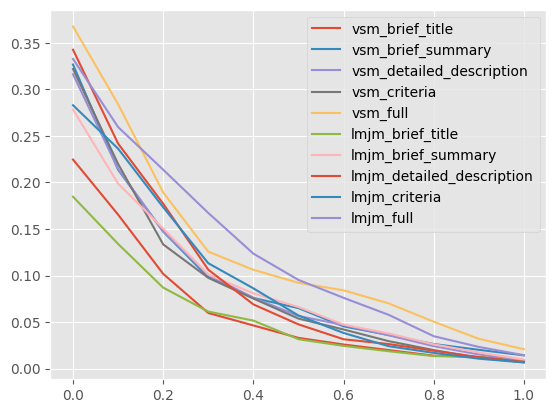

In [24]:
recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for index_name in indexes_list:
    if index_name != 'LETOR_model':
        index = indexes_list[index_name]
        plt.plot(recall_11point, index.mean_precision_11point, label = index_name)
        plt.legend()

plt.show()

In [25]:
results_table = pd.DataFrame(columns =['model', 'p10', 'ndcg5', 'mrr', 'map', 'recall'])
for index_name in indexes_list:
    if index_name != 'LETOR_model':
        index = indexes_list[index_name]
        aa = pd.DataFrame({'model':[index_name], 'p10':[index.m_p10], 'ndcg5':[index.m_ndcg5], 'mrr': [index.m_mrr], 'map':[index.m_ap], 'recall':[index.m_recall]})
        results_table = results_table._append(aa, ignore_index=False)

results_table

,model,p10,ndcg5,mrr,map,recall
0,vsm_brief_title,0.071186,0.064055,0.224646,0.051050,1.0
0,vsm_brief_summary,0.098305,0.120090,0.326781,0.078413,1.0
0,vsm_detailed_description,0.122034,0.119872,0.316304,0.076191,1.0
0,vsm_criteria,0.111864,0.135754,0.321985,0.074324,1.0
0,vsm_full,0.135593,0.143452,0.367623,0.108157,1.0
0,lmjm_brief_title,0.067797,0.055938,0.184726,0.047118,1.0
0,lmjm_brief_summary,0.111864,0.112088,0.278336,0.076736,1.0
0,lmjm_detailed_description,0.120339,0.120531,0.342663,0.076709,1.0
0,lmjm_criteria,0.118644,0.124997,0.283001,0.077923,1.0
0,lmjm_full,0.172881,0.136041,0.332764,0.108977,1.0


LETOR

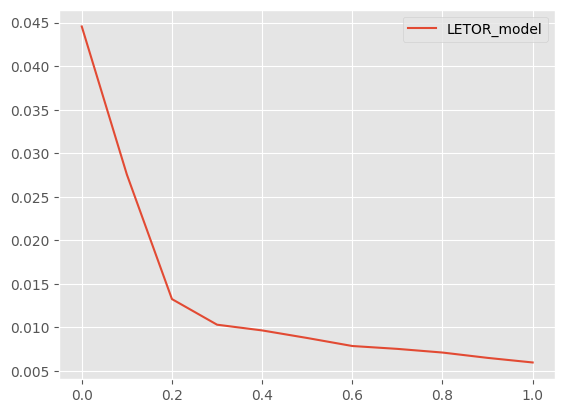

In [64]:
recall_11point = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for index_name in indexes_list:
    if index_name == 'LETOR_model':
        index = indexes_list[index_name]
        plt.plot(recall_11point, index.mean_precision_11point, label = index_name)
        plt.legend()

plt.show()

In [63]:
results_table = pd.DataFrame(columns =['model', 'p10', 'ndcg5', 'mrr', 'map', 'recall'])

for index_name in indexes_list:
    if index_name == 'LETOR_model':
        index = indexes_list[index_name]
        aa = pd.DataFrame({'model':[index_name], 'p10':[index.m_p10], 'ndcg5':[index.m_ndcg5], 'mrr': [index.m_mrr], 'map':[index.m_ap], 'recall':[index.m_recall]})
        results_table = results_table._append(aa, ignore_index=False)

results_table

,model,p10,ndcg5,mrr,map,recall
0,LETOR_model,0.015254,0.009194,0.044562,0.011335,1.0


------------------------------

In [ ]:
# ORIGINAL CELL MADE BY THE TEACHER
index = indexes_list['lmjm_full']
#index = indexes_list['lmjm_brief_title']

query_result = np.sort([index.p10_per_query[caseid] for caseid in cases])
query_text = np.sort([cases[caseid][0:30] for caseid in cases])

#queries_at_indices = [query_text[::-1][i] for i in range(0, len(query_text), 6)]
#print(queries_at_indices)

figure(figsize=(8, 19), dpi=80)

plt.barh(query_text, query_result)

In [49]:
metrics = ['p10', 'ndcg5', 'recall', 'mrr', 'ap']

def get_query_result(selected_index, selected_metric):
    query_result = None
    
    if selected_metric == metrics[0]:
        query_result = np.sort([indexes_list[selected_index].p10_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[1]:
        query_result = np.sort([indexes_list[selected_index].ndcg5_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[2]:
        query_result = np.sort([indexes_list[selected_index].recall_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[3]:
        query_result = np.sort([indexes_list[selected_index].mrr_per_query[caseid] for caseid in cases])
        
    elif selected_metric == metrics[4]:
        query_result = np.sort([indexes_list[selected_index].ap_per_query[caseid] for caseid in cases])
        
    return query_result
    

In [ ]:
# CELL CREATED TO VISUALIZE THE METRICS OF EACH MODEL INDIVIDUALLY WITH EASE

query_texts = np.sort([cases[caseid][0:30] for caseid in cases])

def plot_barh(selected_index, selected_metric):
    plt.figure(figsize=(8, 19), dpi=80)
    
    query_result = get_query_result(selected_index, selected_metric)
        
    y = np.arange(len(query_result))
    
    figure(figsize=(8, 19), dpi=80)

    plt.barh(query_texts, query_result)


index_selector = Dropdown(options=list(indexes_list.keys()))
metric_selector = Dropdown(options=metrics)

interact(plot_barh, selected_index=index_selector, selected_metric = metric_selector)

In [ ]:
# CELL CREATED TO VISUALIZE THE METRICS OF ALL MODELS AT ONCE (MIGHT NEED CHANGING SO MARKERS IN THE CHART DONT OVERLAP)
import plotly.express as px
query_texts = np.sort([cases[caseid][0:30] for caseid in cases])

# Define a function to update the scatter plot
def update_scatter(selected_metric):
    data = []

    for key in indexes_list:
        query_result = get_query_result(key, selected_metric)
        data.extend([(query_result[i], query_texts[i], key) for i in range(len(query_result))])

    df = pd.DataFrame(data, columns=[selected_metric, "Cases", "Model"])

    fig = px.scatter(
        df,
        x=selected_metric,
        y="Cases",
        color="Model",
        title=f"Scatter Plot of {selected_metric}"
    )
    
    fig.update_layout(
        height=1000,
        width=1000,  
    )
    

    fig.show()

# Create a dropdown menu for selecting metrics
metric_selector = Dropdown(options=metrics)

# Use the interact function to update the scatter plot based on the selected metric
interact(update_scatter, selected_metric=metric_selector)

Cross-encoder test

In [ ]:
from sentence_transformers.cross_encoder import CrossEncoder

# Select a cross-encoder model from the Sentence Transformer library and load it in your project.
model = CrossEncoder('cross-encoder/stsb-TinyBERT-L-4') 

# Use only the detailed description field.
field = "_detailed_description"

# Select (1) a query, (2) a relevant document and (3) a non-relevant document.
relevant_id = 77     # NCT00005127
non_relevant_id = 71 # NCT00004727

query = cases["20141"]

relevant_document = vars(full_docs[relevant_id])[field]
non_relevant_document = vars(full_docs[non_relevant_id])[field]

corpus = [relevant_document, non_relevant_document]

#  Format the cross-encoder model input according to the next sentence prediction task
sentence_combinations = [[query, corpus_sentence] for corpus_sentence in corpus]

# Compute the similarity scores for these combinations
similarity_scores = model.predict(sentence_combinations)

relevant_score = similarity_scores[0]
non_relevant_score = similarity_scores[1]

# Sort the scores in decreasing order
sim_scores_argsort = reversed(np.argsort(similarity_scores))

# Print the scores
print("Query:", query)
for idx in sim_scores_argsort:
    print("{:.2f}\t{}".format(similarity_scores[idx], corpus[idx]))
    print("----------------")